In [1]:
import os
import gc
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)

In [2]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    outdir: str = "results"
    device: str = "cuda:1"

    # Data config
    imgdir_name: str = "../../data/ChestXRay14"
    seed: int = 111
    n_splits: int = 5
    label_smoothing: float = 0.0
    # Model config
    model_name: str = "resnet18"
    model_mode: str = "normal"  # normal, cnn_fixed supported
    # Training config
    epoch: int = 20
    lr: float = 1e-3
    batchsize: int = 8
    valid_batchsize: int = 16
    num_workers: int = 4
    snapshot_freq: int = 5
    ema_decay: float = 0.999  # negative value is to inactivate ema.
    scheduler_type: str = ""
    scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    scheduler_trigger: List[Union[int, str]] = field(default_factory=lambda: [1, "iteration"])
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = 0.

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
import albumentations as A


class Transform:
    def __init__(self, aug_kwargs: Dict):
        self.transform = A.Compose([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return image

In [4]:
import torch
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F
import timm
from sklearn.metrics import average_precision_score


class CNNFixedPredictor(nn.Module):
    def __init__(self, cnn: nn.Module, num_classes: int = 2):
        super(CNNFixedPredictor, self).__init__()
        self.cnn = cnn
        self.lin = Linear(cnn.num_features, num_classes)
        print("cnn.num_features", cnn.num_features)

        # We do not learn CNN parameters.
        # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.cnn(x)
        return self.lin(feat)


def build_predictor(model_name: str, model_mode: str = "normal"):
    if model_mode == "normal":
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=True, num_classes=2, in_chans=3)
    elif model_mode == "cnn_fixed":
        # normal configuration. train all parameters.
        # https://rwightman.github.io/pytorch-image-models/feature_extraction/
        timm_model = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        return CNNFixedPredictor(timm_model, num_classes=2)
    else:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_mode}")

        
def accuracy(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape[:-1] == t.shape, f"y {y.shape}, t {t.shape} is inconsistent."
    pred_label = torch.max(y.detach(), dim=-1)[1]
    count = t.nelement()
    correct = (pred_label == t).sum().float()
    acc = correct / count
    return acc


def accuracy_with_logits(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape == t.shape
    gt_label = torch.max(t.detach(), dim=-1)[1]
    return accuracy(y, gt_label)


def cross_entropy_with_logits(input, target, dim=-1):
    loss = torch.sum(- target * F.log_softmax(input, dim), dim)
    return loss.mean()


def average_precision(y: torch.Tensor, t: torch.Tensor) -> float:
    """For binary classification"""
    assert y.shape == t.shape
    y = torch.softmax(y, dim=-1).detach().cpu().numpy()[:, 1]
    t = np.where(t.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)  # undo label smoothing
    return average_precision_score(t, y)  # probability of True labels


import torch
import torch.nn.functional as F
from torch import nn
import pytorch_pfn_extras as ppe


class Classifier(nn.Module):
    """two class classfication"""

    def __init__(self, predictor, lossfun=cross_entropy_with_logits):
        super().__init__()
        self.predictor = predictor
        self.lossfun = lossfun
        self.prefix = ""

    def forward(self, image, targets):
        outputs = self.predictor(image)
        loss = self.lossfun(outputs, targets)
        metrics = {
            f"{self.prefix}loss": loss.item(),
            f"{self.prefix}acc": accuracy_with_logits(outputs, targets).item(),
            f"{self.prefix}ap": average_precision(outputs, targets)
        }
        ppe.reporting.report(metrics, self)
        return loss, metrics

    def predict(self, data_loader):
        pred = self.predict_proba(data_loader)
        label = torch.argmax(pred, dim=1)
        return label

    def predict_proba(self, data_loader):
        device: torch.device = next(self.parameters()).device
        y_list = []
        self.eval()
        with torch.no_grad():
            for batch in tqdm(data_loader):
                if isinstance(batch, (tuple, list)):
                    # Assumes first argument is "image"
                    batch = batch[0].to(device)
                else:
                    batch = batch.to(device)
                y = self.predictor(batch)
                y = torch.softmax(y, dim=-1)
                y_list.append(y)
        pred = torch.cat(y_list)
        return pred

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [5]:
"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
from logging import getLogger
from torch import nn


class EMA(object):
    """Exponential moving average of model parameters.

    Ref
     - https://github.com/tensorflow/addons/blob/v0.10.0/tensorflow_addons/optimizers/moving_average.py#L26-L103
     - https://anmoljoshi.com/Pytorch-Dicussions/

    Args:
        model (nn.Module): Model with parameters whose EMA will be kept.
        decay (float): Decay rate for exponential moving average.
        strict (bool): Apply strict check for `assign` & `resume`.
        use_dynamic_decay (bool): Dynamically change decay rate. If `True`, small decay rate is
            used at the beginning of training to move moving average faster.
    """  # NOQA

    def __init__(
        self,
        model: nn.Module,
        decay: float,
        strict: bool = True,
        use_dynamic_decay: bool = True,
    ):
        self.decay = decay
        self.model = model
        self.strict = strict
        self.use_dynamic_decay = use_dynamic_decay
        self.logger = getLogger(__name__)
        self.n_step = 0

        self.shadow = {}
        self.original = {}

        # Flag to manage which parameter is assigned.
        # When `False`, original model's parameter is used.
        # When `True` (`assign` method is called), `shadow` parameter (ema param) is used.
        self._assigned = False

        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def step(self):
        self.n_step += 1
        if self.use_dynamic_decay:
            _n_step = float(self.n_step)
            decay = min(self.decay, (1.0 + _n_step) / (10.0 + _n_step))
        else:
            decay = self.decay

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    # alias
    __call__ = step

    def assign(self):
        """Assign exponential moving average of parameter values to the respective parameters."""
        if self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `assign` is called again before `resume`.")
            else:
                self.logger.warning(
                    "`assign` is called again before `resume`."
                    "shadow parameter is already assigned, skip."
                )
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]
        self._assigned = True

    def resume(self):
        """Restore original parameters to a model.

        That is, put back the values that were in each parameter at the last call to `assign`.
        """
        if not self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `resume` is called before `assign`.")
            else:
                self.logger.warning("`resume` is called before `assign`, skip.")
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]
        self._assigned = False


"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
from typing import Mapping, Any
from torch import optim
from pytorch_pfn_extras.training.extension import Extension, PRIORITY_READER
from pytorch_pfn_extras.training.manager import ExtensionsManager


class LRScheduler(Extension):
    """A thin wrapper to resume the lr_scheduler"""

    trigger = 1, 'iteration'
    priority = PRIORITY_READER
    name = None

    def __init__(self, optimizer: optim.Optimizer, scheduler_type: str, scheduler_kwargs: Mapping[str, Any]) -> None:
        super().__init__()
        self.scheduler = getattr(optim.lr_scheduler, scheduler_type)(optimizer, **scheduler_kwargs)

    def __call__(self, manager: ExtensionsManager) -> None:
        self.scheduler.step()

    def state_dict(self) -> None:
        return self.scheduler.state_dict()

    def load_state_dict(self, to_load) -> None:
        self.scheduler.load_state_dict(to_load)


from ignite.engine import Engine


def create_trainer(model, optimizer, device) -> Engine:
    model.to(device)

    def update_fn(engine, batch):
        model.train()
        optimizer.zero_grad()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        loss.backward()
        optimizer.step()
        return metrics
    trainer = Engine(update_fn)
    return trainer

In [6]:
import random


class ChestRayDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths: List[str], labels: List[int], label_smoothing: float = 0., mixup_prob: float = 0., image_transform: Transform = None, oversample: bool = False):
        self.filepaths = filepaths
        self.labels = labels
        if oversample:
            self.__oversample()
        
        self.label_smoothing = label_smoothing
        self.mixup_prob = mixup_prob
        self.image_transform = image_transform
        
    def __len__(self) -> int:
        return len(self.filepaths)
    
    def __getitem__(self, idx: int):
        img, label = self.__get_single_example(idx=idx)
        img, label = self.__mixup(img=img, label=label)
        
        label_logit = torch.tensor([1 - label, label], dtype=torch.float32)
        
        return img, label_logit
    
    def __get_single_example(self, idx: int) -> Tuple[torch.Tensor, float]:
        img = cv2.imread(self.filepaths[idx])
        if self.image_transform:
            img = self.image_transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))
        
        label = self.labels[idx]
        if label == 0:
            return img, float(label) + self.label_smoothing
        else:
            return img, float(label) - self.label_smoothing
    
    def __mixup(self, img: torch.Tensor, label: float):
        if np.random.uniform() < self.mixup_prob:
            pair_idx = np.random.randint(0, len(self.filepaths))
            prob = np.random.uniform()
            pair_img, pair_label = self.__get_single_example(idx=pair_idx)
            img = img * self.mixup_prob + pair_img * (1 - self.mixup_prob)
            label = label * self.mixup_prob + pair_label * (1 - self.mixup_prob)
        return img, label
    
    def __oversample(self):
        labels = np.array(self.labels)
        n_pos, n_neg = (labels == 1).sum(), (labels == 0).sum()
        
        sample_class = 1 if n_pos < n_neg else 0
        n_sample = np.abs(n_pos - n_neg)
        
        print(f'#Positive: {n_pos}, #Negative: {n_neg}  | over sample: Class{sample_class} {n_sample}')
        
        population = np.where(labels == sample_class)[0]
        random.seed(111)
        sample_idx = random.choices(population.tolist(), k=n_sample)
        
        self.filepaths += np.array(self.filepaths)[sample_idx].tolist()
        self.labels += np.array(self.labels)[sample_idx].tolist()

In [7]:
from sklearn.model_selection import StratifiedKFold
import cv2
from torch.utils.data.dataset import Dataset


class StratifiedKFoldWrapper:
    def __init__(self, datadir: Path, n_splits: int, shuffle: bool, seed: int, 
                 label_smoothing: float = 0., mixup_prob: float = 0., aug_kwargs: Dict = {}):
        self.datadir = datadir
        fl = self.__load_filelist()
        fp = self.__load_filepath()
        
        self.datalist = pd.merge(fl, fp, how='left', on='Image Index')[['Image Index', 'Normal', 'Patient ID', 'File Path', 'No Finding Rate']]
        self.datalist = self.datalist.rename(columns={'Image Index': 'image_index', 'Normal': 'normal', 'Patient ID': 'patient_id', 'File Path': 'filepath', 'No Finding Rate': 'no_finding_rate'})
        self.datalist = self.datalist.query("(no_finding_rate == 0) | (no_finding_rate == 1)").reset_index(drop=True)
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
        self.split_idxs = list(skf.split(self.datalist['filepath'].values, self.datalist['normal'].values))
        self.__i = -1
        
        self.label_smoothing = label_smoothing
        self.mixup_prob = mixup_prob
        self.image_transform = Transform(aug_kwargs=aug_kwargs)
        
    def __load_filelist(self):
        df = pd.read_csv(self.datadir / 'Data_Entry_2017.csv')
        df1 = df.groupby('Patient ID').first().reset_index()
        df2 = df.groupby('Patient ID')['Finding Labels'].agg(lambda x: (x == 'No Finding').sum() / len(x)).reset_index()
        df2.columns = ['Patient ID', 'No Finding Rate']
        df = pd.merge(df1, df2, how='inner', on='Patient ID')[['Patient ID', 'Image Index', 'No Finding Rate']]
        df['Normal'] = (df['No Finding Rate'] == 1).astype('int8')
        
        del df1, df2
        gc.collect()
        
        return df
        
    def __load_filepath(self):
        records = {'Image Index': [], 'File Path': []}
        
        for dn in [tmp for tmp in sorted(os.listdir(self.datadir)) if 'image' in tmp]:
            for fn in sorted(os.listdir(self.datadir / dn / 'images')):
                records['Image Index'] += [fn]
                records['File Path'] += [str(self.datadir / dn / 'images' / fn)]
                
        return pd.DataFrame(records)
    
    def __iter__(self):
        self.__i = -1
        return self

    def __next__(self):
        self.__i += 1
        if self.__i < 0 or len(self.split_idxs) <= self.__i:
            raise StopIteration()
        return self.generate_datasets()
    
    def __len__(self) -> int:
        return len(self.split_idxs)
    
    def __getitem__(self, idx):
        if idx < 0 or len(self.split_idxs) <= idx:
            raise ValueError()
        self.__i = idx
        return self.generate_datasets()
        
    def generate_datasets(self) -> ChestRayDataset:
        train_idx, valid_idx = self.split_idxs[self.__i]
        
        train_ds = ChestRayDataset(
            filepaths=self.datalist['filepath'].values[train_idx].tolist(),
            labels=self.datalist['normal'].values[train_idx].tolist(),
            label_smoothing=self.label_smoothing,
            mixup_prob=self.mixup_prob,
            image_transform=self.image_transform,
            oversample=True
        )
        valid_ds = ChestRayDataset(
            filepaths=self.datalist['filepath'].values[valid_idx].tolist(),
            labels=self.datalist['normal'].values[valid_idx].tolist(),
        )
        
        return train_ds, valid_ds

In [8]:
config_dict = {
    # Model
    "model_name": "resnet18",
    # Training
    "num_workers": 4,
    "epoch": 5,
    "batchsize": 32,
    "lr": 1e-3,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 28125},  # 15000 * 15 epoch // (batchsize=8)
    "scheduler_trigger": [1, "iteration"],
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    },
    "mixup_prob": 0.3
}

config = Config().update(config_dict)

base_dir = Path().resolve()

In [9]:
skf = StratifiedKFoldWrapper(
    datadir=base_dir / config.imgdir_name,
    n_splits=config.n_splits,
    shuffle=True,
    seed=config.seed,
    label_smoothing=config.label_smoothing,
    mixup_prob=config.mixup_prob,
    aug_kwargs=config.aug_kwargs
)

In [10]:
config

Config(outdir='results', device='cuda:1', imgdir_name='../../data/ChestXRay14', seed=111, n_splits=5, label_smoothing=0.0, model_name='resnet18', model_mode='normal', epoch=5, lr=0.001, batchsize=32, valid_batchsize=16, num_workers=4, snapshot_freq=5, ema_decay=0.999, scheduler_type='CosineAnnealingWarmRestarts', scheduler_kwargs={'T_0': 28125}, scheduler_trigger=[1, 'iteration'], aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=0.3)

In [11]:
import dataclasses
import pytorch_pfn_extras.training.extensions as E
import torch
from ignite.engine import Events
from pytorch_pfn_extras.training import IgniteExtensionsManager
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.nn import DataParallel

In [ ]:
# Only 0-th fold

fold = 0
train_dataset, valid_dataset = skf[fold]

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batchsize,
    num_workers=config.num_workers,
    shuffle=True,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.valid_batchsize,
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=True,
)

device = torch.device(config.device)

predictor = build_predictor(model_name=config.model_name, model_mode=config.model_mode)
classifier = Classifier(predictor)
model = classifier
# model = DataParallel(model)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=config.lr)

# Train setup
trainer = create_trainer(model, optimizer, device)

ema = EMA(predictor, decay=config.ema_decay)

def eval_func(*batch):
    loss, metrics = model(*[elem.to(device) for elem in batch])
    # HACKING: report ema value with prefix.
    if config.ema_decay > 0:
        classifier.prefix = "ema_"
        ema.assign()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        ema.resume()
        classifier.prefix = ""

valid_evaluator = E.Evaluator(
    valid_loader, model, progress_bar=False, eval_func=eval_func, device=device
)

# log_trigger = (10 if debug else 1000, "iteration")
log_trigger = (1, "epoch")
log_report = E.LogReport(trigger=log_trigger)
extensions = [
    log_report,
    E.ProgressBarNotebook(update_interval=100),  # Show progress bar during training
    E.PrintReportNotebook(),  # Show "log" on jupyter notebook  
    E.FailOnNonNumber(),  # Stop training when nan is detected.
]

models = {"main": model}
optimizers = {"main": optimizer}
manager = IgniteExtensionsManager(
    trainer, models, optimizers, config.epoch, extensions=extensions, out_dir=str(base_dir / config.outdir),
)
# Run evaluation for valid dataset in each epoch.
manager.extend(valid_evaluator)

# Save predictor.pt every epoch
manager.extend(
    E.snapshot_object(predictor, "predictor.pt"), trigger=(config.snapshot_freq, "epoch")
)
# Check & Save best validation predictor.pt every epoch
# manager.extend(E.snapshot_object(predictor, "best_predictor.pt"),
#                trigger=MinValueTrigger("validation/module/nll",
#                trigger=(flags.snapshot_freq, "iteration")))

# --- lr scheduler ---
if config.scheduler_type != "":
    print(f"using {config.scheduler_type} scheduler with kwargs {config.scheduler_kwargs}")
    manager.extend(
        LRScheduler(optimizer, config.scheduler_type, config.scheduler_kwargs),
        trigger=config.scheduler_trigger,
    )

manager.extend(E.observe_lr(optimizer=optimizer), trigger=log_trigger)

if config.ema_decay > 0:
    # Exponential moving average
    manager.extend(lambda manager: ema(), trigger=(1, "iteration"))

    def save_ema_model(manager):
        ema.assign()
        torch.save(predictor.state_dict(), str(base_dir / config.outdir / "predictor_ema.pt"))
        ema.resume()

    manager.extend(save_ema_model, trigger=(config.snapshot_freq, "epoch"))

_ = trainer.run(train_loader, max_epochs=config.epoch)

#Positive: 13122, #Negative: 4718  | over sample: Class0 8404
using CosineAnnealingWarmRestarts scheduler with kwargs {'T_0': 28125}


HTML(value='')

In [ ]:
torch.save(predictor.state_dict(), base_dir / config.outdir / "predictor_last.pt")

In [ ]:
df = log_report.to_dataframe()
df.to_csv(base_dir / config.outdir / "log.csv", index=False)
df

In [17]:
classifier.eval()

valid_pred = classifier.predict_proba(valid_loader).cpu().numpy()
valid_pred_df = pd.DataFrame({
    "class0": valid_pred[:, 0],
    "class1": valid_pred[:, 1],
    "truth": valid_dataset.labels
})

  0%|          | 0/279 [00:00<?, ?it/s]

In [18]:
from sklearn.metrics import average_precision_score

average_precision_score(valid_pred_df['truth'].values, valid_pred_df['class1'].values)

0.7819029318607309

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(valid_pred_df['truth'], valid_pred_df['class1'] > 0.5)

0.7354853171934543

/home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


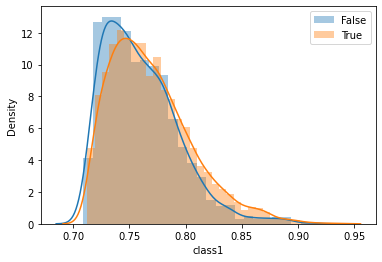

In [25]:
fig, ax = plt.subplots(1, 1)
sns.distplot(valid_pred_df.query('truth == 0')['class1'], ax=ax, label='False')
sns.distplot(valid_pred_df.query('truth == 1')['class1'], ax=ax, label='True')
ax.legend()
plt.show()